In [23]:
import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas.tools import sjoin
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('data/ventas_mvdeo_2022-08-03_depurado.csv')
print(data.shape)
data.head()

(597, 10)


,desc,valor,metraje,url,lat,lng,dormitorios,barrio,barrio_ine,cod_barrio_ine
0,3 Dormitorios en Aires Puros,190000,110.0,https://www.gallito.com.uy/excelente-garaje-2-...,NaN,NaN,3 Dormitorios,Aires Puros,Aires Puros,29.0
1,2 Dormitorios en Colon,45000,50.0,https://www.gallito.com.uy/oficina-sosa-proxim...,-34.80505,-56.23007,2 Dormitorios,Colon,"Colón Sureste, Abayubá",58.0
2,4 Dormitorios en Cerrito,45000,97.0,https://www.gallito.com.uy/oportunidad-casa-de...,-34.85944,-56.15642,4 Dormitorios,Cerrito,Cerrito,27.0
3,1 Dormitorio en Villa Española,48000,39.0,https://www.gallito.com.uy/oficina-sosa-apto-1...,-32.87555,-56.02015,1 Dormitorio,Villa Española,Villa Española,24.0
4,2 Dormitorios en La Teja,48000,50.0,https://www.gallito.com.uy/casa-a-1-cuadra-de-...,-34.86604,-56.23782,2 Dormitorios,La Teja,La Teja,38.0


In [5]:
print('Sin coordenadas:', sum(data.lat.isna()))

Sin coordenadas: 168


In [6]:
geodata = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.lng, data.lat), crs=4326).to_crs(32721)

geodata['valor_metro'] = geodata.valor / geodata.metraje

geodata.head(2)

,desc,valor,metraje,url,lat,lng,dormitorios,barrio,barrio_ine,cod_barrio_ine,geometry,valor_metro
0,3 Dormitorios en Aires Puros,190000,110.0,https://www.gallito.com.uy/excelente-garaje-2-...,NaN,NaN,3 Dormitorios,Aires Puros,Aires Puros,29.0,POINT EMPTY,1727.272727
1,2 Dormitorios en Colon,45000,50.0,https://www.gallito.com.uy/oficina-sosa-proxim...,-34.80505,-56.23007,2 Dormitorios,Colon,"Colón Sureste, Abayubá",58.0,POINT (570424.356 6148305.711),900.000000


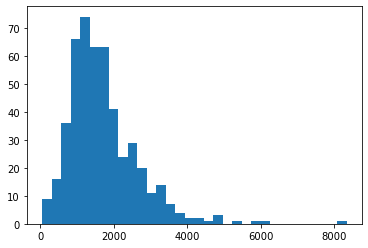

In [24]:
plt.hist(geodata['valor_metro'], bins='auto')

plt.show()

In [8]:
geodata['valor'].describe(percentiles=[.05, .5, .95])

count    5.970000e+02
mean     3.244379e+05
std      3.651381e+05
min      4.500000e+04
5%       5.000000e+04
50%      2.100000e+05
95%      1.490000e+06
max      1.800000e+06
Name: valor, dtype: float64

In [9]:
geodata['metraje'].describe(percentiles=[.05, .5, .95])

count     500.000000
mean      194.090000
std       212.502538
min         1.000000
5%         45.000000
50%       132.500000
95%       541.000000
max      2662.000000
Name: metraje, dtype: float64

In [10]:
geodata['metraje'].describe(percentiles=[.05, .5, .95])

count     500.000000
mean      194.090000
std       212.502538
min         1.000000
5%         45.000000
50%       132.500000
95%       541.000000
max      2662.000000
Name: metraje, dtype: float64

In [11]:
geodata[geodata['valor_metro'] == 6.000000e+06]

,desc,valor,metraje,url,lat,lng,dormitorios,barrio,barrio_ine,cod_barrio_ine,geometry,valor_metro


In [12]:
max(geodata.metraje)

2662.0

In [13]:
geodata[geodata['metraje'] > 5000]

,desc,valor,metraje,url,lat,lng,dormitorios,barrio,barrio_ine,cod_barrio_ine,geometry,valor_metro


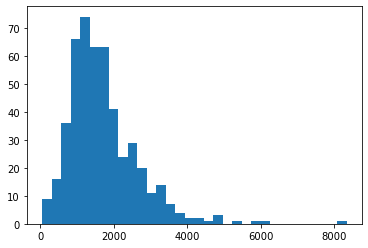

In [25]:
# depura outliers
geodata = geodata.loc[(geodata.metraje > 10) & (geodata.metraje < 5000)]

plt.hist(geodata['valor_metro'], bins='auto')

plt.show()

In [26]:
barrios = gpd.read_file('capas/barrios_ine_uy.zip').set_crs(32721)
barrios.head(2)

,area_km,nombbarr,nrobarrio,geometry
0,2.111,CIUDAD VIEJA,1,"POLYGON ((573146.276 6137144.661, 573148.256 6..."
1,31.795,COLON SURESTE - ABAYUBA,58,"POLYGON ((571329.308 6147787.334, 571320.034 6..."


In [27]:
pegue = sjoin(geodata, barrios.loc[:,['nrobarrio', 'geometry']], how="left")
pegue.head(2)

,desc,valor,metraje,url,lat,lng,dormitorios,barrio,barrio_ine,cod_barrio_ine,geometry,valor_metro,index_right,nrobarrio
0,3 Dormitorios en Aires Puros,190000,110.0,https://www.gallito.com.uy/excelente-garaje-2-...,NaN,NaN,3 Dormitorios,Aires Puros,Aires Puros,29.0,POINT EMPTY,1727.272727,NaN,NaN
1,2 Dormitorios en Colon,45000,50.0,https://www.gallito.com.uy/oficina-sosa-proxim...,-34.80505,-56.23007,2 Dormitorios,Colon,"Colón Sureste, Abayubá",58.0,POINT (570424.356 6148305.711),900.000000,59.0,59.0


In [28]:
pegue.loc[(pegue.barrio != pegue.barrio_ine) & (~pegue.nrobarrio.isna()), 'cod_barrio_ine'] = pegue.nrobarrio

In [29]:
pegue.head(2)

,desc,valor,metraje,url,lat,lng,dormitorios,barrio,barrio_ine,cod_barrio_ine,geometry,valor_metro,index_right,nrobarrio
0,3 Dormitorios en Aires Puros,190000,110.0,https://www.gallito.com.uy/excelente-garaje-2-...,NaN,NaN,3 Dormitorios,Aires Puros,Aires Puros,29.0,POINT EMPTY,1727.272727,NaN,NaN
1,2 Dormitorios en Colon,45000,50.0,https://www.gallito.com.uy/oficina-sosa-proxim...,-34.80505,-56.23007,2 Dormitorios,Colon,"Colón Sureste, Abayubá",59.0,POINT (570424.356 6148305.711),900.000000,59.0,59.0


In [30]:
raros = pegue.loc[(pegue.cod_barrio_ine != pegue.nrobarrio) & (~pegue.nrobarrio.isna())]
raros.shape


(81, 14)

In [31]:
pegue.loc[(pegue.barrio != pegue.barrio_ine) & (~pegue.nrobarrio.isna()), 'cod_barrio_ine'] = pegue.nrobarrio

In [32]:
agru = pegue.groupby('cod_barrio_ine').median('valor_metro').reset_index()

agru['cod_barrio_ine'] = agru['cod_barrio_ine'].astype(int)

agru.head()

,cod_barrio_ine,valor,metraje,lat,lng,valor_metro,index_right,nrobarrio
0,1,304000.0,205.0,-34.905220,-56.205750,1495.000000,0.0,1.0
1,2,140000.0,140.0,-34.907210,-56.190270,944.301587,9.0,2.0
2,3,175000.0,177.0,-34.911430,-56.190400,988.700565,10.0,3.0
3,4,280000.0,195.0,-34.904465,-56.178105,1415.458937,11.0,4.0
4,5,225000.0,145.0,-34.909480,-56.180900,1526.355997,11.5,4.5


In [33]:
cols = ['cod_barrio_ine', 'valor_metro']

geo = pd.merge(barrios, agru[cols], how='left', left_on='nrobarrio', right_on='cod_barrio_ine')
geo.head()

,area_km,nombbarr,nrobarrio,geometry,cod_barrio_ine,valor_metro
0,2.111,CIUDAD VIEJA,1,"POLYGON ((573146.276 6137144.661, 573148.256 6...",1.0,1495.000000
1,31.795,COLON SURESTE - ABAYUBA,58,"POLYGON ((571329.308 6147787.334, 571320.034 6...",58.0,1080.246914
2,2.783,TRES OMBUES - VICTORIA,56,"POLYGON ((569357.162 6141087.122, 569333.377 6...",NaN,NaN
3,0.784,LA BLANQUEADA,47,"POLYGON ((578073.764 6139184.407, 578112.591 6...",47.0,1382.727273
4,1.873,BRAZO ORIENTAL,51,"POLYGON ((574735.970 6140971.174, 574735.915 6...",51.0,1590.909091


In [35]:
geo.to_file('capas/median_2022-08-03.gpkg', driver="GPKG")

In [36]:
geo.valor_metro.median()

1245.2446466007787

### Hexágonos

In [37]:
grid = gpd.read_file('capas/grilla_hex.gpkg').set_crs(32721)
grid.head(2)

,id,geometry
0,555,"POLYGON ((556312.789 6147560.250, 556457.127 6..."
1,554,"POLYGON ((556312.789 6148060.250, 556457.127 6..."


In [38]:
pegue = sjoin(grid, geodata, how="left")
pegue.head()

,id,geometry,index_right,desc,valor,metraje,url,lat,lng,dormitorios,barrio,barrio_ine,cod_barrio_ine,valor_metro
0,555,"POLYGON ((556312.789 6147560.250, 556457.127 6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,554,"POLYGON ((556312.789 6148060.250, 556457.127 6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,553,"POLYGON ((556312.789 6148560.250, 556457.127 6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,552,"POLYGON ((556312.789 6149060.250, 556457.127 6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,559,"POLYGON ((556312.789 6145560.250, 556457.127 6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
pegue.valor_metro.max()

8333.333333333334

In [40]:
agru = pegue.groupby('id').median('valor_metro').reset_index()

agru.head()

,id,index_right,valor,metraje,lat,lng,cod_barrio_ine,valor_metro
0,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
data_grid = grid.merge(agru, on='id', how='left')[['id', 'valor_metro', 'geometry']]

In [42]:
data_grid.to_file('capas/grid_median_2022-08-03.gpkg', driver="GPKG")